# Imports

In [1]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import networkx as nx
from node2vec import Node2Vec
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import scipy

C:\Users\Ayan\anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Ayan\anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\Ayan\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


# Load data

In [2]:
soc_reddit_body = pd.read_csv('soc-redditHyperlinks-body.tsv', sep='\t')

In [3]:
soc_reddit_body.head()

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,LINK_SENTIMENT,PROPERTIES
0,leagueoflegends,teamredditteams,1u4nrps,2013-12-31 16:39:58,1,"345.0,298.0,0.75652173913,0.0173913043478,0.08..."
1,theredlion,soccer,1u4qkd,2013-12-31 18:18:37,-1,"101.0,98.0,0.742574257426,0.019801980198,0.049..."
2,inlandempire,bikela,1u4qlzs,2014-01-01 14:54:35,1,"85.0,85.0,0.752941176471,0.0235294117647,0.082..."
3,nfl,cfb,1u4sjvs,2013-12-31 17:37:55,1,"1124.0,949.0,0.772241992883,0.0017793594306,0...."
4,playmygame,gamedev,1u4w5ss,2014-01-01 02:51:13,1,"715.0,622.0,0.777622377622,0.00699300699301,0...."


In [4]:
embed_subreddit = pd.read_csv('web-redditEmbeddings-subreddits.csv')

In [5]:
embed_subreddit.head()

,spiders,0.158972,0.285813,0.226329,-0.183338,-0.163159,-0.18891,0.422705,0.168602,0.178193,...,-0.025041,0.184655,0.111942,-1.125799,0.223129,-0.387323,-0.234882,-0.252297,-0.054315,0.500009
0,askreddit,-0.499114,0.323983,-0.424809,-0.222705,-0.327201,0.412856,1.040088,0.996697,-1.256240,...,0.072151,0.226658,0.535705,0.039861,-0.027087,-0.239952,0.554510,0.676439,-0.328846,0.941547
1,globaloffensivetrade,-0.023145,-1.199374,1.661484,-1.025296,1.424670,-1.179507,-1.035703,0.329301,-0.567272,...,2.998430,-1.235703,-0.326850,4.381238,-1.965378,-2.369674,-0.615389,2.010601,-0.919314,-2.149625
2,fireteams,2.492506,-2.529917,-0.448484,-3.543441,-0.586122,-0.101517,1.837567,-0.215715,-2.460388,...,-1.875214,0.969291,0.497958,2.941132,2.423561,1.315691,-0.959618,0.151845,-0.852492,-0.467526
3,funny,-0.819370,-0.865261,0.301753,0.018787,0.201029,0.070462,0.903895,1.038460,-0.306950,...,1.364194,0.830233,-0.137822,-2.204667,-0.162008,0.390291,-0.556404,0.322684,0.641634,1.320716
4,the_donald,-0.123265,-0.610208,0.361495,-1.171773,0.367407,0.624919,2.420601,-0.447998,1.393862,...,0.981761,1.044754,-2.334628,-0.005856,-1.647531,-0.139574,-0.284726,0.315069,-0.846018,0.800535


In [6]:
nodes = set(soc_reddit_body['SOURCE_SUBREDDIT'].tolist()).union(set(soc_reddit_body['TARGET_SUBREDDIT'].tolist()))

In [7]:
len(nodes)

35776

In [8]:
node_emb_names = []
node_embd_vec = []

for j in tqdm(range(len(embed_subreddit))):
    node_emb_names.append(embed_subreddit.iloc[j].tolist()[0])
    node_embd_vec.append(embed_subreddit.iloc[j].tolist()[1:302])

100%|███████████████████████████████████████████████████████████████████████████| 51277/51277 [01:11<00:00, 716.26it/s]


In [9]:
node_embd_name_vec = dict(zip(node_emb_names,node_embd_vec))

In [10]:
len(node_emb_names)

51277

In [11]:
len(nodes.intersection(set(node_emb_names)))

21674

In [12]:
node_1_embed = []
node_2_embed = []
year_list = []
found_1 = []
found_2 = []

for index, row in tqdm(soc_reddit_body.iterrows()):
    year_list.append(row['TIMESTAMP'].split()[0].split('-')[0])
    try:
        node_1_embed.append(node_embd_name_vec[row['SOURCE_SUBREDDIT']])
        found_1.append(1)
    except:
        node_1_embed.append([0]*300)
        found_1.append(0)
    try:
        node_2_embed.append(node_embd_name_vec[row['TARGET_SUBREDDIT']])
        found_2.append(1)
    except:
        node_2_embed.append([0]*300)
        found_2.append(0)

print(set(year_list))

286561it [01:43, 2764.39it/s]

{'2017', '2015', '2016', '2013', '2014'}


In [13]:
soc_reddit_body['year'] = year_list
soc_reddit_body['source_embed'] = node_1_embed
soc_reddit_body['target_embed'] = node_2_embed
soc_reddit_body['found_1'] = found_1
soc_reddit_body['found_2'] = found_2

In [14]:
soc_reddit_body

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,LINK_SENTIMENT,PROPERTIES,year,source_embed,target_embed,found_1,found_2
0,leagueoflegends,teamredditteams,1u4nrps,2013-12-31 16:39:58,1,"345.0,298.0,0.75652173913,0.0173913043478,0.08...",2013,"[-2.785298, -0.166391, 1.592624, -1.269829, 2....","[-1.402933, -1.1156540000000001, 0.921651, -0....",1,1
1,theredlion,soccer,1u4qkd,2013-12-31 18:18:37,-1,"101.0,98.0,0.742574257426,0.019801980198,0.049...",2013,"[-0.239977, -0.24648299999999998, 0.0596789999...","[-2.7988470000000003, -1.243099, 0.513319, 0.1...",1,1
2,inlandempire,bikela,1u4qlzs,2014-01-01 14:54:35,1,"85.0,85.0,0.752941176471,0.0235294117647,0.082...",2014,"[0.070123, -0.001389, 0.143414, -0.46698900000...","[0.15803, 0.035602999999999996, 0.197221, -0.4...",1,1
3,nfl,cfb,1u4sjvs,2013-12-31 17:37:55,1,"1124.0,949.0,0.772241992883,0.0017793594306,0....",2013,"[-0.41374399999999995, 0.13559300000000002, -0...","[-0.5422899999999999, 1.0747719999999998, 0.23...",1,1
4,playmygame,gamedev,1u4w5ss,2014-01-01 02:51:13,1,"715.0,622.0,0.777622377622,0.00699300699301,0....",2014,"[0.006368, -0.135252, 0.45853299999999997, -0....","[-0.033949, 0.15096600000000002, 1.039643, -0....",1,1
...,...,...,...,...,...,...,...,...,...,...,...
286556,negareddit,debatefascism,68im20s,2017-04-30 16:31:26,1,"441.0,405.0,0.775510204082,0.0294784580499,0.0...",2017,"[-0.392242, 0.186111, 0.203193, -0.441168, 0.3...","[-0.202682, 0.126838, -0.077966, -0.2579079999...",1,1
286557,mildlynomil,justnomil,68imlas,2017-04-30 04:19:03,1,"2226.0,1855.0,0.786163522013,0.00224618149146,...",2017,"[-0.008284, -0.075661, 0.082401, -0.049988, 0....","[0.124855, -0.792166, 0.149331, 0.376434999999...",1,1
286558,mmorpg,blackdesertonline,68ip5os,2017-04-30 16:54:08,1,"1100.0,909.0,0.778181818182,0.00181818181818,0...",2017,"[0.008334999999999999, 0.0209, 0.9342010000000...","[-0.272359, -0.833299, 1.339546, -0.268322, 0....",1,1
286559,electricskateboards,askreddit,68ipb2s,2017-04-30 16:41:53,1,"1876.0,1567.0,0.78144989339,0.00692963752665,0...",2017,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.49911400000000006, 0.32398299999999997, -0...",0,1


# Trains on 2014 and test on 2015

In [15]:
train = soc_reddit_body[soc_reddit_body['year'] == '2014']
test = soc_reddit_body[soc_reddit_body['year'] == '2015']
print(len(train),len(test))

63344 88575


In [16]:
train_nodes = set(train['SOURCE_SUBREDDIT'].tolist()).union(set(train['TARGET_SUBREDDIT'].tolist()))
test_nodes = set(test['SOURCE_SUBREDDIT'].tolist()).union(set(test['TARGET_SUBREDDIT'].tolist()))
print('Inductive nodes: ', len(test_nodes.difference(train_nodes)))

Inductive nodes:  10397


In [17]:
inductive_nodes = test_nodes.difference(train_nodes)
inductive_test = test[test['SOURCE_SUBREDDIT'].isin(inductive_nodes) | test['TARGET_SUBREDDIT'].isin(inductive_nodes)]
print('Size of inductive test set: ', len(inductive_test))

Size of inductive test set:  27174


In [18]:
train_valid = train[train['found_1'].isin([1]) & train['found_2'].isin([1])]
print(len(train_valid))
inductive_test_valid = inductive_test[inductive_test['found_1'].isin([1]) & inductive_test['found_2'].isin([1])]
print(len(inductive_test_valid))

57432
19308


In [19]:
train_valid = train_valid[['SOURCE_SUBREDDIT','TARGET_SUBREDDIT', 'year', 'source_embed', 'target_embed']]
inductive_test_valid = inductive_test_valid[['SOURCE_SUBREDDIT','TARGET_SUBREDDIT', 'year', 'source_embed', 'target_embed']]

## Generating negatives

In [20]:
train_valid_node_dict = dict()

for index, row in tqdm(train_valid.iterrows()):
    train_valid_node_dict[row['SOURCE_SUBREDDIT']] = row['source_embed']
    train_valid_node_dict[row['TARGET_SUBREDDIT']] = row['target_embed']
    
inductive_test_valid_node_dict = dict()

for index, row in tqdm(inductive_test_valid.iterrows()):
    inductive_test_valid_node_dict[row['SOURCE_SUBREDDIT']] = row['source_embed']
    inductive_test_valid_node_dict[row['TARGET_SUBREDDIT']] = row['target_embed']

57432it [00:20, 2862.46it/s]
19308it [00:07, 2628.43it/s]


In [21]:
train_neg = pd.DataFrame()

source_list = []
target_list = []
year_list = []
source_embed_list = []
target_embed_list = []

for j in tqdm(range(len(train_valid))):
    
    src = np.random.choice(list(train_valid_node_dict.keys()))
    trgt = np.random.choice(list(train_valid_node_dict.keys()))
    
    source_list.append(src)
    target_list.append(trgt)
    year_list.append(2014)
    source_embed_list.append(train_valid_node_dict[src])
    target_embed_list.append(train_valid_node_dict[trgt])
    
train_neg['SOURCE_SUBREDDIT'] = source_list
train_neg['TARGET_SUBREDDIT'] = target_list
train_neg['year'] = year_list
train_neg['source_embed'] = source_embed_list
train_neg['target_embed'] = target_embed_list

train_all = pd.concat([train_valid,train_neg])
train_all['label'] = [1] * len(train_valid) + [0] * len(train_neg)
train_all

100%|███████████████████████████████████████████████████████████████████████████| 57432/57432 [08:19<00:00, 114.93it/s]


,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,year,source_embed,target_embed,label
2,inlandempire,bikela,2014,"[0.070123, -0.001389, 0.143414, -0.46698900000...","[0.15803, 0.035602999999999996, 0.197221, -0.4...",1
4,playmygame,gamedev,2014,"[0.006368, -0.135252, 0.45853299999999997, -0....","[-0.033949, 0.15096600000000002, 1.039643, -0....",1
6,locationbot,legaladvice,2014,"[-0.024395, -0.10246300000000001, 0.1047, -0.1...","[-0.038085, -0.42014399999999996, 0.501881, -0...",1
12,metalcore,corejerk,2014,"[0.137185, -0.854073, 0.731183, -0.15904000000...","[-0.086075, -0.15501900000000002, 0.255759, -0...",1
13,suicidewatch,offmychest,2014,"[-0.157389, -0.387517, 0.039486, -0.081951, -0...","[0.05609, -0.558994, 0.232145, -0.324627, -0.7...",1
...,...,...,...,...,...,...
57427,jewelry,outrun,2014,"[0.039037999999999996, -0.174991, 0.290458, -0...","[0.288521, -0.40058, 0.544103, -0.117414, -0.1...",0
57428,cougars,mohawkcollege,2014,"[0.28274099999999996, -0.292031, 0.134601, -0....","[-0.00687, -0.068535, 0.08112, -0.063935, -0.0...",0
57429,southpark,carlint,2014,"[-0.185758, -0.140241, 0.374648, -0.216367, 0....","[-0.006228, -0.139921, 0.135352, -0.0558059999...",0
57430,watchinganime,zettairyouiki,2014,"[0.0098, -0.088652, 0.101825, 0.040482, -0.024...","[-0.142283, -0.50003, -0.146522, 0.053336, 0.1...",0


In [22]:
inductive_test_valid_neg = pd.DataFrame()

source_list = []
target_list = []
year_list = []
source_embed_list = []
target_embed_list = []

for j in tqdm(range(len(inductive_test_valid))):
    
    src = np.random.choice(list(inductive_test_valid_node_dict.keys()))
    trgt = np.random.choice(list(inductive_test_valid_node_dict.keys()))
    
    source_list.append(src)
    target_list.append(trgt)
    year_list.append(2015)
    source_embed_list.append(inductive_test_valid_node_dict[src])
    target_embed_list.append(inductive_test_valid_node_dict[trgt])
    
inductive_test_valid_neg['SOURCE_SUBREDDIT'] = source_list
inductive_test_valid_neg['TARGET_SUBREDDIT'] = target_list
inductive_test_valid_neg['year'] = year_list
inductive_test_valid_neg['source_embed'] = source_embed_list
inductive_test_valid_neg['target_embed'] = target_embed_list

test_all = pd.concat([inductive_test_valid,inductive_test_valid_neg])
test_all['label'] = [1] * len(inductive_test_valid) + [0] * len(inductive_test_valid_neg)
test_all

100%|███████████████████████████████████████████████████████████████████████████| 19308/19308 [02:25<00:00, 133.11it/s]


,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,year,source_embed,target_embed,label
33403,myporn,rule34,2015,"[-0.004232, -0.06867899999999999, 0.049444, -0...","[0.455794, 0.153378, 0.082485, -0.719597, 0.66...",1
42206,shane_solo,ea_nhl,2015,"[-0.030695, -0.12401, 0.063593, -0.014331, 0.0...","[-0.073781, -0.29944499999999996, 0.171374, -0...",1
60570,swindon,bath,2015,"[-0.003353, -0.07499199999999999, 0.078898, -0...","[-0.024038, -0.15322, 0.136251, -0.134689, 0.0...",1
61440,hockeybots,hockey,2015,"[-0.005503, -0.023642, 0.044422, -0.037558, 0....","[-0.087811, 0.070745, 0.21230900000000003, -0....",1
63296,buildapc,coolguides,2015,"[-0.633564, -0.42006499999999997, 1.206392, -0...","[-0.022381, 0.050523, 0.083562, -0.082738, -0....",1
...,...,...,...,...,...,...
19303,cryptocurrency,tankporn,2015,"[-0.055773, -0.889733, 0.44955900000000004, -0...","[-0.23514000000000002, 0.05752, 0.171561, -0.2...",0
19304,aetherforged,kickstarter,2015,"[-0.024597, -0.13309400000000002, 0.1216589999...","[0.198371, 0.074378, 0.65133, -0.5074569999999...",0
19305,mashups,bloodbornesliders,2015,"[0.24205700000000002, -0.523368, 0.462667, -0....","[-0.005212, -0.10521400000000002, 0.101974, -0...",0
19306,athiesm,yogscastlive,2015,"[-0.029039999999999996, -0.10974500000000001, ...","[-0.042602999999999995, -0.05773, 0.0393660000...",0


# Train and test classifier

In [23]:
X_train = []

for index, row in tqdm(train_all.iterrows()):
    X_train.append(row['source_embed'] + row['target_embed'])
    
X_test = []

for index, row in tqdm(test_all.iterrows()):
    X_test.append(row['source_embed'] + row['target_embed'])

114864it [00:31, 3698.19it/s]
38616it [00:11, 3497.70it/s]


In [24]:
clf = MLPClassifier(hidden_layer_sizes=(3,100),
                    random_state=5,
                    verbose=True,
                    learning_rate_init=0.01)

In [25]:
y_train = train_all['label'].tolist()
clf.fit(X_train,y_train)

Iteration 1, loss = 0.39650011
Iteration 2, loss = 0.36211923
Iteration 3, loss = 0.35324105
Iteration 4, loss = 0.34894151
Iteration 5, loss = 0.34690480
Iteration 6, loss = 0.34421390
Iteration 7, loss = 0.34256939
Iteration 8, loss = 0.34127333
Iteration 9, loss = 0.34038551
Iteration 10, loss = 0.33892728
Iteration 11, loss = 0.33796951
Iteration 12, loss = 0.33740645
Iteration 13, loss = 0.33594861
Iteration 14, loss = 0.33516688
Iteration 15, loss = 0.33464926
Iteration 16, loss = 0.33416734
Iteration 17, loss = 0.33275545
Iteration 18, loss = 0.33222974
Iteration 19, loss = 0.33205070
Iteration 20, loss = 0.33065387
Iteration 21, loss = 0.32994288
Iteration 22, loss = 0.32888313
Iteration 23, loss = 0.32878802
Iteration 24, loss = 0.32851339
Iteration 25, loss = 0.32816034
Iteration 26, loss = 0.32819700
Iteration 27, loss = 0.32752949
Iteration 28, loss = 0.32673886
Iteration 29, loss = 0.32699118
Iteration 30, loss = 0.32670172
Iteration 31, loss = 0.32637377
Iteration 32, los

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(3, 100), learning_rate='constant',
              learning_rate_init=0.01, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=5, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=True,
              warm_start=False)

In [107]:
#y = clf.loss_curve_
#y_normalized = [i - min(y) for i in clf.loss_curve_]
#x = range(len(clf.loss_curve_))
#coeff = np.polyfit(x, np.log(y_normalized), 1, w=np.sqrt(y_normalized))
#print(coeff)

In [85]:
#y = clf.loss_curve_
#y_normalized = [i - min(y) for i in clf.loss_curve_]
#x = range(len(clf.loss_curve_))

#coeff = scipy.optimize.curve_fit(lambda t,a,b: a*np.exp(-b*t),  x,  y_normalized)

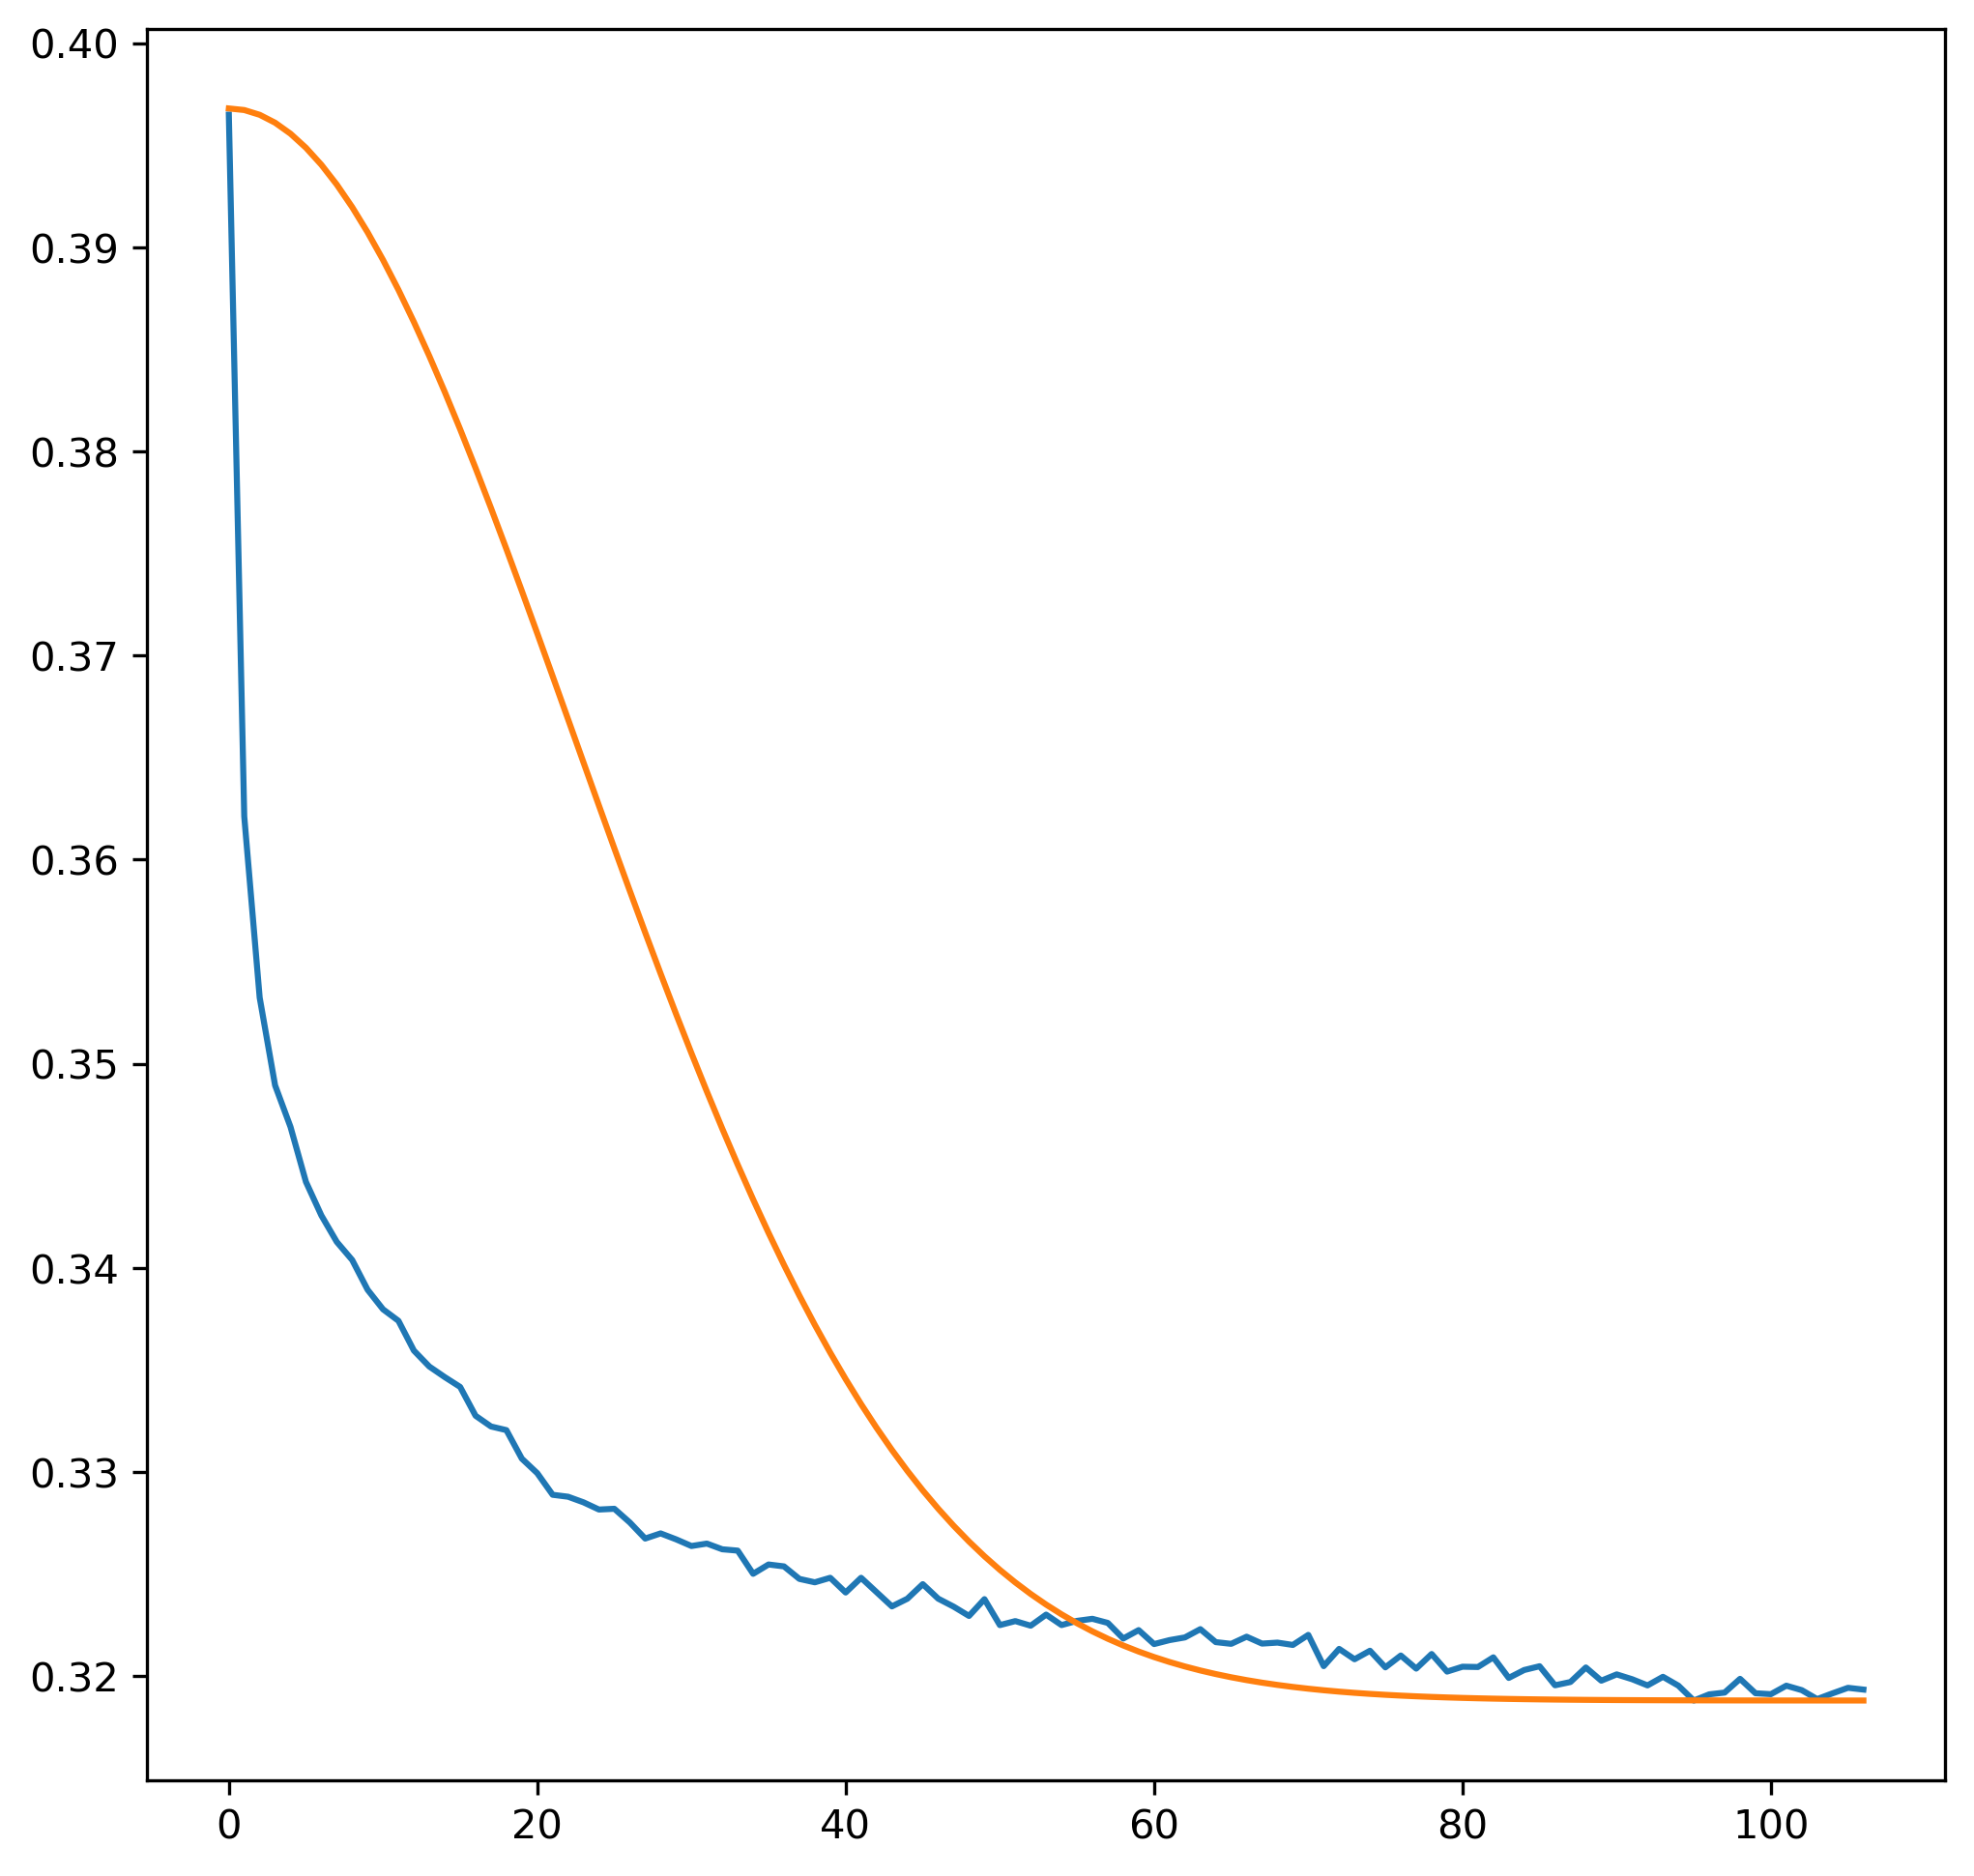

In [110]:
## Sub-gaussian nature of the loss function
plt.figure(figsize=(8, 8), dpi=300)
coeff_0 = 0.078
coeff_1 = 0.001
plt.plot(range(len(clf.loss_curve_)),clf.loss_curve_)
plt.plot(range(0,len(clf.loss_curve_)),[coeff_0*np.exp(-(coeff_1*x*x)) + min(y) for x in range(0,len(clf.loss_curve_))])

In [52]:
ypred = clf.predict(X_test)

In [55]:
print('AUROC:', roc_auc_score(test_all['label'].tolist(), ypred))
print('AUPRC:', average_precision_score(test_all['label'].tolist(), ypred))

AUROC: 0.7030246529935779
AUPRC: 0.6673617919721178


# Random Shuffling

In [56]:
def crazyshuffle(arr):
    
    x, y = arr.shape
    rows = np.indices((x,y))[0]
    cols = [np.random.permutation(y) for _ in range(x)]
    
    return arr[rows, cols]

In [59]:
X_train_shuffle = np.array(X_train)
X_train_shuffle = crazyshuffle(X_train_shuffle)

clf_shuffled = MLPClassifier(hidden_layer_sizes=(3,100),
                    random_state=5,
                    verbose=True,
                    learning_rate_init=0.01)

clf_shuffled.fit(X_train_shuffle,y_train)


Iteration 1, loss = 0.57641787
Iteration 2, loss = 0.54741355
Iteration 3, loss = 0.53655503
Iteration 4, loss = 0.53097501
Iteration 5, loss = 0.52556443
Iteration 6, loss = 0.52272278
Iteration 7, loss = 0.52048121
Iteration 8, loss = 0.51850998
Iteration 9, loss = 0.51641573
Iteration 10, loss = 0.51571576
Iteration 11, loss = 0.51416683
Iteration 12, loss = 0.51315364
Iteration 13, loss = 0.51226401
Iteration 14, loss = 0.51114535
Iteration 15, loss = 0.50995380
Iteration 16, loss = 0.50972857
Iteration 17, loss = 0.50905019
Iteration 18, loss = 0.50858503
Iteration 19, loss = 0.50816662
Iteration 20, loss = 0.50753076
Iteration 21, loss = 0.50720324
Iteration 22, loss = 0.50630006
Iteration 23, loss = 0.50641186
Iteration 24, loss = 0.50630123
Iteration 25, loss = 0.50558824
Iteration 26, loss = 0.50545346
Iteration 27, loss = 0.50499266
Iteration 28, loss = 0.50526716
Iteration 29, loss = 0.50452142
Iteration 30, loss = 0.50426896
Iteration 31, loss = 0.50402900
Iteration 32, los

In [62]:
ypred_shuffle = clf_shuffled.predict(X_test)

print('AUROC:', roc_auc_score(test_all['label'].tolist(), ypred_shuffle))
print('AUPRC:', average_precision_score(test_all['label'].tolist(), ypred_shuffle))

AUROC: 0.6678319867412471
AUPRC: 0.6219774079577194


# Random features

In [65]:
X_train_rand = np.random.rand(np.array(X_train).shape[0],np.array(X_train).shape[1])

clf_rand = MLPClassifier(hidden_layer_sizes=(3,100),
                    random_state=5,
                    verbose=True,
                    learning_rate_init=0.01)

clf_rand.fit(X_train_rand,y_train)

ypred_rand = clf_rand.predict(X_test)

print('AUROC:', roc_auc_score(test_all['label'].tolist(), ypred_rand))
print('AUPRC:', average_precision_score(test_all['label'].tolist(), ypred_rand))

Iteration 1, loss = 0.69377971
Iteration 2, loss = 0.69334975
Iteration 3, loss = 0.69331794
Iteration 4, loss = 0.69323643
Iteration 5, loss = 0.69326658
Iteration 6, loss = 0.69317283
Iteration 7, loss = 0.69320143
Iteration 8, loss = 0.69326444
Iteration 9, loss = 0.69319801
Iteration 10, loss = 0.69324038
Iteration 11, loss = 0.69323181
Iteration 12, loss = 0.69325437
Iteration 13, loss = 0.69319474
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
AUROC: 0.5
AUPRC: 0.5


# Davis-Bouldin Score

In [69]:
k_clusters = 5

attributes_kmeans = KMeans(n_clusters=k_clusters, random_state=0).fit(X_train)
print(davies_bouldin_score(X_train,attributes_kmeans.labels_))
      
shuffle_kmeans = KMeans(n_clusters=k_clusters, random_state=0).fit(X_train_shuffle)
print(davies_bouldin_score(X_train_shuffle,shuffle_kmeans.labels_))
      
rand_kmeans = KMeans(n_clusters=k_clusters, random_state=0).fit(X_train_rand)
print(davies_bouldin_score(X_train_rand,rand_kmeans.labels_))

2.9036008488030385
20.561104058100163
21.97783351845107


In [70]:
k_clusters = 10

attributes_kmeans = KMeans(n_clusters=k_clusters, random_state=0).fit(X_train)
print(davies_bouldin_score(X_train,attributes_kmeans.labels_))
      
shuffle_kmeans = KMeans(n_clusters=k_clusters, random_state=0).fit(X_train_shuffle)
print(davies_bouldin_score(X_train_shuffle,shuffle_kmeans.labels_))
      
rand_kmeans = KMeans(n_clusters=k_clusters, random_state=0).fit(X_train_rand)
print(davies_bouldin_score(X_train_rand,rand_kmeans.labels_))

2.3433695903057243
11.429696476605915
18.504317550093152
